In [24]:
from typing import TypedDict, Annotated, List
from langgraph.graph import StateGraph, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage
from langchain_core.language_models import BaseChatModel
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough

from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()


# Define the state
class AssistantState(MessagesState):
    task_decision: str
    database_agent_response: str


# Mock function for CrewAI backend (replace with actual implementation)
def query_crewai_backend(query: str) -> str:
    # Simulate CrewAI backend response
    return input("Enter CrewAI agent response: ")


def get_chat_model() -> BaseChatModel:
    return ChatGroq(model="llama-3.1-70b-versatile")


# Node functions
def main_conversation(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "You are a helpful assistant for a student. Respond based on the conversation and any information from the agents."),
        ("human", "{input}"),
        ("ai", "CrewAI Agent info: {database_agent_response}\nResponse:"),
    ])
    chain = prompt | chat
    response = chain.invoke({
        "input": state["messages"][-1].content,
        "database_agent_response": state.get("database_agent_response", "No additional information available.")
    })
    return {"messages": [AIMessage(content=response.content)]}


def task_planning(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system",
         "Decide if we need to consult the CrewAI agents for more information or if we can respond directly. Output 'query' or 'respond'. If you don't know the answer for ANY QUESTION, output 'query'."),
        ("human", "{input}"),
    ])
    chain = prompt | chat
    decision = chain.invoke({"input": state["messages"][-1].content})
    print(f"{decision.content.strip().lower()=}")
    return {"task_decision": decision.content.strip().lower()}


def crewai_agent_query(state: AssistantState) -> AssistantState:
    chat = get_chat_model()
    prompt = ChatPromptTemplate.from_messages([
        ("system", "Formulate a natural language query for the CrewAI agents based on the student's question."),
        ("human", "{input}"),
    ])
    chain = prompt | chat
    result = chain.invoke({"input": state["messages"][-1].content})
    print(f'{result.content=}')
    return {"database_agent_response": query_crewai_backend(result.content)}

In [25]:
# Create the graph
workflow = StateGraph(AssistantState)

# Add nodes
workflow.add_node("main_conversation", main_conversation)
workflow.add_node("task_planning", task_planning)
workflow.add_node("crewai_agent_query", crewai_agent_query)

# Add edges
workflow.set_entry_point("task_planning")
workflow.add_conditional_edges(
    "task_planning",
    lambda x: "crewai_agent_query" if x["task_decision"] == "query" else (
        "main_conversation" if x["task_decision"] == "respond" else "task_planning"),
    {
        "crewai_agent_query": "crewai_agent_query",
        "main_conversation": "main_conversation",
        "task_planning": "task_planning"
    }
)
workflow.add_edge("crewai_agent_query", "main_conversation")
workflow.add_edge("main_conversation", END)

# Compile the graph
app = workflow.compile()

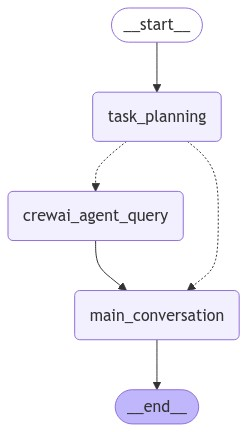

In [26]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(app.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.API)))

In [27]:
messages = []
while True:
    messages.append(HumanMessage(content=input("You:")))
    result = app.invoke({"messages": messages})
    print("\n\nFinal result:")
    print(result['messages'][-1].content)

KeyboardInterrupt: Interrupted by user